In [27]:
import psycopg2
import gc
from psycopg2.extensions import register_adapter, AsIs
from time import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def obtainMaxRecords(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT replace(split_part(record, '/',3),'s',''),max(record) "
                      " FROM rstq "
                      " WHERE cast(replace(split_part(record, '/',3),'s','') as integer) "
                      " NOT IN (select subject_id from subjectrecord) "
                      " AND centroid IS NOT NULL"
                      " GROUP BY split_part(record, '/',3)"
    )
    cur.execute(select_stament)
    subject = []
    for row in cur :
        subject.append({"subject_id":int(row[0]),"record":row[1]})
    conn.close()
    return subject

In [3]:
def insert(words,table,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement = 'INSERT into '+table+' (%s) values %s'
    columns = words.keys()
    values = [words[column] for column in columns]
#    print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
    cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    cur.close()
    conn.close()

In [4]:
def fillsubjectRecord() :
    for subject in obtainMaxRecords() :
        insert(subject,"subjectrecord")

In [5]:
def obtainSubjects(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT subject_id,record "
                      " FROM subjectrecord"
    )
    cur.execute(select_stament)
    subject = []
    for row in cur :
        subject.append({"subject_id":int(row[0]),"record":row[1]})
    cur.close()
    conn.close()
    return subject

In [6]:
def patientIsAlive(patient,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT dod "
                      " FROM patients WHERE subject_id = "+str(patient)+" LIMIT 1"
    )
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append(1 if row[0] is not None else 0 )
    cur.close()
    conn.close()
    return select

In [7]:
def obtainWord(subject,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT centroid "
                      " FROM rstq WHERE record='"+str(subject)+"' ORDER BY r_s"
    )
    cur.execute(select_stament)
    centroids = ""
    for row in cur :
        centroid = row[0]
        if centroid is not None :
            centroids= centroids+centroid
    conn.close()
    return centroids

In [8]:
def deleteWord(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "DELETE FROM subjectwords"
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()

In [12]:
def insertSubjectWords(words,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO subjectwords(word,subject_id,isalive)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(subject_id)s) ,'
                      ' unnest( %(isalive)s)')
    word=[r['word'] for r in words]
    subject_id=[r['subject_id'] for r in words]
    isalive=[r['isalive'] for r in words]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [13]:
def createListOfWords() :
    subjects = obtainSubjects()
    lenSubjects = len(subjects)
    deleteWord()
    i,j=0,0
    words = []
    for subject in subjects :
        subject_id = subject['subject_id']
        isAlive = patientIsAlive(subject_id)
        if isAlive != [] :
            j=j+1
            word = obtainWord(subject['record'])
            if word is not None:
                words.append({'subject_id':subject_id,'word':word,'isalive':isAlive[0]})
    insertSubjectWords(words)
    print()
    print("In a list of "+str(lenSubjects)+" we know the status of "+str(j)+" patients")

In [10]:
def existMatrix(word,subject,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT 1 "
                      " FROM matrix WHERE subject_id='"+str(subject)+"' AND word='"+str(word)+"'"
    )
    cur.execute(select_stament)
    exist = False
    for row in cur :
        exist = True
    cur.close()
    conn.close()
    return exist

In [79]:
def printGroups(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT count(1),LENGTH(word) FROM subjectwords GROUP BY LENGTH(word) ORDER BY LENGTH(word)"
    )
    cur.execute(select_stament)
    words = []
    maximun = 0
    for row in cur :
        words.append({"subjects":row[0],"wordSize":row[1]})
        maximun = maximun if maximun>row[1] else row[1]
    cur.close()
    conn.close()
    division = maximun/8
    means_men = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,}
    for r in words :
        for x in range(0, 9):
            if(r['wordSize']>=division*x and r['wordSize']<division*(x+1)):
                means_men[str(x)] = means_men[str(x)]+r['subjects']
    columns = sorted(means_men.keys())
    means_men = [means_men[column] for column in sorted(means_men)]
    index = np.arange(len(means_men))
    bar_width = 0.35
    plt.bar(index,means_men,label='Subjects')
    plt.xlabel('Lenght of Words')
    plt.ylabel('Subjects')
    plt.title('Subjects by Lenght of words')
    plt.xticks(index + bar_width / 2, (columns))
    plt.legend()
#    plt.tight_layout()
    plt.show()

In [45]:
t0 = time()
fillsubjectRecord()
print("done in %0.3fs." % (time() - t0))
gc.collect()
t0 = time()
createListOfWords()
print("done in %0.3fs." % (time() - t0))

done in 78.715s.

In a list of 737 we know the status of 713 patients
done in 529.058s.


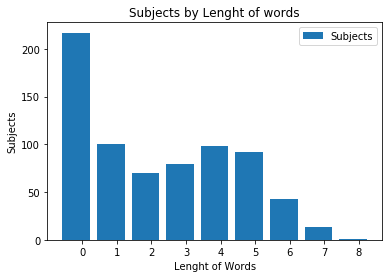

In [80]:
printGroups()